## Fouled-off balls
What kinds of pitches are fouled off?

How do fouled-off pitches differ from called/swinging strikes, or other pitch outcomes?

Features that might matter: ball/strike count, pitch type, pitch location, pitch velocity, etc.

In [38]:
# Import the necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# PITCHfx data from 2016 Jun 1–3, parsed using the `pfx_parser_csv.py` script
data = pd.read_csv('edited_pitch_table.csv')

In [ ]:
data.head()     # To see what the data looks like

In [ ]:
list(data)     # Returns all column headers

In [ ]:
data.shape
# 64 features
# 12,134 samples (pitches) in this three day period

In [49]:
#Split dataset into fouls and not-fouls
thefouls = data[data['pitch_res'] == 'F']
notfouls = data[data['pitch_res'] != 'F']
print('Fouls: ', thefouls.shape, 'Not Fouls: ', notfouls.shape)
# 2050 pitches were fouled off, 10,084 were not fouled off, unbalanced dataset.

Fouls:  (2050, 64) Not Fouls:  (10084, 64)


Possible approaches:
1. Focus on fouled-off pitches, do K-means clustering do identify types of situations that lead to fouled-off pitches
2. Try to classify pitches as fouled or not-fouled, then investigate feature importance

I like the second approach to start with, maybe the first to follow-up

### Encoding the categorical variables

Several features are categorical, so they need to be encoded as 0/1s for each possible value

In [ ]:
# Which features are categorical?
X.dtypes
# Pitcher hand, batter hand, pitch sequence, pitch type, pitch type sequence

In [3]:
# Use pd.get_dummies() to encode these categorical variables
catcols = ['pit_hand_cd', 'bat_hand_cd', 'pitch_type']
hots = pd.get_dummies(data, columns=catcols, prefix = catcols)
hots.head()
# Seems to work!

,retro_game_id,year,st_fl,regseason_fl,playoffs_fl,game_type,game_type_des,game_id,home_team_id,home_team_lg,...,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_SI,pitch_type_SL
0,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,1,0,0,0,0,0,0,0,0
1,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,1,0,0,0,0,0,0,0,0,0
2,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,1,0,0,0,0,0,0,0,0
3,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,1,0,0,0,0,0,0,0,0
4,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,1,0,0,0,0,0,0,0,0,0


In [4]:
# Some rows have missing values, so drop them (not sure exactly where/what they are right now)
hots = hots.dropna()
hots.shape    # 20 samples dropped, due to the encoding, not sure why?

(12114, 78)

In [5]:
# Split data into X and y
'''We can look at all pitch outcomes first, then later focus on just fouls'''
y = hots['pitch_res']
# X needs to exclude old encoded columns, but also stuff like the gameID, teamIDs, etc...
dropcols = [
    'retro_game_id',
    'year',
    'st_fl',
    'regseason_fl',
    'playoffs_fl',
    'game_type',
    'game_type_des',
    'game_id',
    'home_team_id',
    'home_team_lg',
    'away_team_id',
    'away_team_lg',
    'interleague_fl',
    'park_name',
    'park_lock',
    'pitch_seq',      # Too difficult to encode, unfortunately...
    'pa_terminal_fl',
    'pa_event_cd',
    'pitch_res',
    'pitch_des',
    'pitch_id',
    'pitch_type_seq',    # Too difficult to encode, unfortunately...
    'sv_id',
    'x', 'y',     # Older, less useful PitchFX features, now replaced by 'px' and 'pz'
    'y0'          # Distance between the pitcher's release point and home plate, held constant by definition in the PitchFX data
]
X = hots.drop(dropcols, axis=1)
print('X: ', X.shape, 'y: ', y.shape)

X:  (12114, 52) y:  (12114,)


In [6]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
# Fit a Random forest classifier to the training set
pitchresultsforest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
pitchresultsforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [8]:
pitchresultsforest.score(X_test, y_test)
# 5 possible outcomes right now (will change to foul T/F later), so .5 is better than chance (0.2), but not great

0.54677338669334663

In [9]:
# Feature importances
colsX = pd.Series(X_test.columns.values)
imps = pd.concat([colsX, pd.Series(pitchresultsforest.feature_importances_)], axis=1).reset_index()
imps.columns = ['index', 'feature', 'importance']
imps.sort_values(by='importance', ascending=0)   # Sorted by importance

,index,feature,importance
32,32,zone,0.099538
18,18,px,0.078567
19,19,pz,0.073011
24,24,vz0,0.037489
22,22,vx0,0.031463
21,21,z0,0.029108
20,20,x0,0.027839
27,27,az,0.027500
31,31,type_conf,0.027390
6,6,pa_strike_ct,0.027322


## Random forest classification: all pitch outcomes
* Looked at ALL pitch outcomes (swinging/called strike, ball, foul, in play, etc.)
* **Most important features**:
    * Pitch location (zone, px, pz)
    * Velocity (vz0, vx0)
    * Release point (x0, z0), this is somewhat surprising to me
    * The batter involved (bat_id)
    * Strike count
* **Non-important features**:
    * Batter/pitcher handedness
    * Pitch type!
    * Game situation (inning, number of outs, men on base, etc.)
    * Park effects

I think these are pretty intuitive results, but it's cool to see them quantified!

Should look into exactly what pitch locations, velocities, etc. lead to each outcome.

Next though, rather than consider all pitch outcomes, let's focus exclusively on fouled vs. not-fouled pitches.

In [10]:
#Use pd.get_dummies() again to easily draw out the fouled-off balls
possres = list(set(y))
outcomes = pd.get_dummies(y, columns=possres)
fouls = outcomes['F']

In [14]:
'''IMPORTANT: Create sample weights to rebalance the data!'''
numnotfoul = len(fouls[fouls == 0])
numfoul = len(fouls[fouls == 1])
coefweight = numnotfoul / numfoul
print(coefweight)   # ~4.92x more not-fouls than fouls (will differ slightly with each train/test split)
sampweight = fouls.replace(0, coefweight)

4.917928676111383


In [12]:
# Train/test split with fouls this time instead of full y
X_train, X_test, y_train, y_test, samp_train, samp_test = train_test_split(X, fouls, sampweight, test_size=0.33, random_state=42)

In [15]:
# Random Forest Classification on foul T/F
foulforest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
foulforest.fit(X_train, y_train, sample_weight = samp_train.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [16]:
# Need to include sample weights when assessing accuracy now
foulforest.score(X_test, y_test, sample_weight=samp_test.values)
# accuracy of 0.95, pretty good!

0.95015508320742459

In [17]:
# Feature importances, if interested
colsX = pd.Series(X_test.columns.values)
imps = pd.concat([colsX, pd.Series(foulforest.feature_importances_)], axis=1).reset_index()
imps.columns = ['index', 'feature', 'importance']
imps.sort_values(by='importance', ascending=0)   # Sorted by importance

,index,feature,importance
19,19,pz,0.042577
26,26,ay,0.039726
18,18,px,0.039328
21,21,z0,0.038743
24,24,vz0,0.037461
20,20,x0,0.036906
22,22,vx0,0.036516
31,31,type_conf,0.036211
17,17,pfx_z,0.036186
34,34,spin_rate,0.035394


## Random forest classification: foul T/F

The model seems pretty accurate as classifying pitches as fouls or not-fouls!

However, the feature importance is not terribly informative. Location seems to matter to a small degree (px/pz).

I'm not clear how the 'ay' feature (acceleration from the pitcher's mound to home plate) substantively differs from velocity (vy0), but apparently it is much more important feature.

It may help to delve into how each individual feature affects these pitch outcomes. Coming soon!

The importance of 'type_conf' is really interesting to me. That feature is PITCHfx's own confidence in classifying that pitch's type. While that seems purely technical, perhaps that confidence affects batters as well, and their ability to react properly or make good contact. Would like to look into this more as well.

## Visualizing pitch location on fouls and not-fouls

Let's make heat maps to see exactly how pitch locations affects pitch outcomes

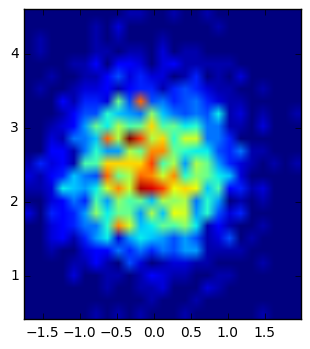

In [57]:
# Heat map of pitches that were fouled-off
thefouls = thefouls.dropna()

heatmap, xedges, yedges = np.histogram2d(thefouls['px'], thefouls['pz'], bins = 25)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

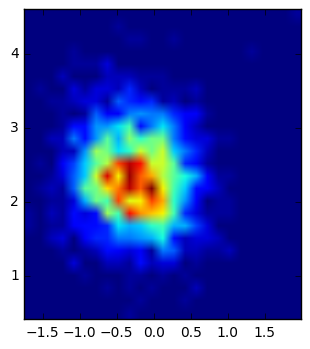

In [61]:
# Heat map of pitches that were NOT fouled off
notfouls = notfouls.dropna()

# Let's equalize the sample sizes, to make these heatmaps more easily comparable
notfset = notfouls.take(np.random.permutation(len(notfouls))[:len(thefouls)])

heatmap, xedges, yedges = np.histogram2d(notfset['px'], notfset['pz'], bins = 25)
# Use the same extent as the fouls dataset in the cell above

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

Fouled-off pitches appear to be more scattered around the plate, but I find these somewhat difficult to directly compare (without making something like an animated gif...).

So it's somewhat surprising that pitch location rates as the most important feature in determining whether a pitch will be fouled off or not. Those importance values were indeed quite low, so it's a complex combination of features that really determine it in the end.